# STREAM benchmark

Results from STREAM benchmark.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs-jitter')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Array size

STREAM benchmark uses 3 arrays of size `N` to run different kernels. We use the total array size of the benchmark in such a way that they occupy 60% of the system memory to avoid caching effects of the benchmark.

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

In [4]:
df = modules.utils.tabulate_last_perf(test='Stream*',
                                     root=PERFLOG_DIR,
                                     extras=['array_size'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case'])
display(df)

perf_var                                                           Add  \
case                                               array_size            
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788  44911.1   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788  56946.0   

perf_var                                                          Copy  \
case                                               array_size            
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788  39230.3   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788  54788.0   

perf_var                                                         Scale  \
case                                               array_size            
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788  39225.3   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788  52144.1   

perf_var                                                         Triad  
case                                               array_size           
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788  44929.8  
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788  57180.1

## Performance History

The plot shows the **Triad bandwidths** for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

1 2


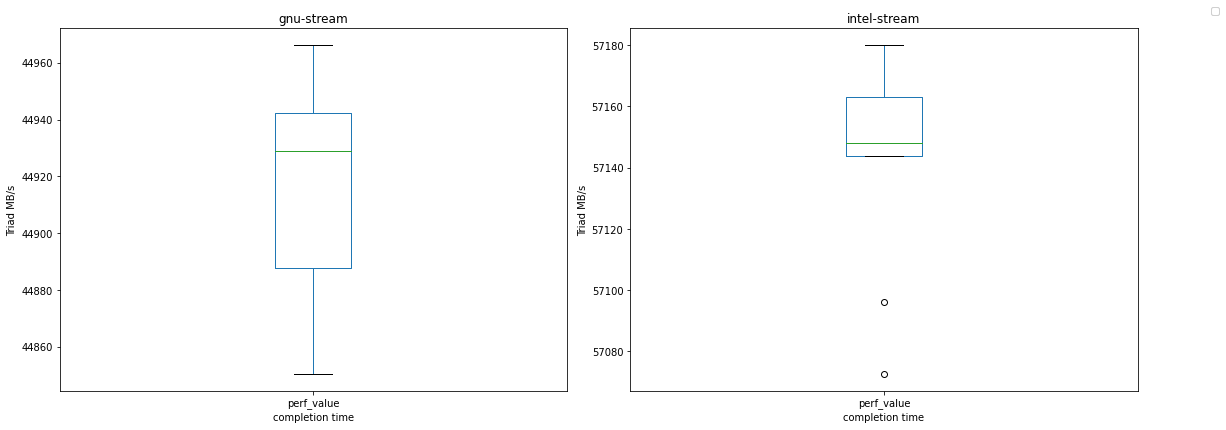

In [31]:
test='Stream'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['array_size'], test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
    
recs = perf_records.groupby(['sysname', 'partition', 'environ'])
n_cols = 2
n_rows = (len(recs)+(n_cols-1)) // n_cols
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8*n_cols, 6*n_rows))
ax = ax.flatten()
for idx, (spe, data) in enumerate(recs):
    # filter to only Gflops records (might have others)
    data = data.loc[data['perf_var'] == 'Triad']
    data.boxplot(ax=ax[idx], column='perf_value')
    
    ax[idx].set_title(spe[2])
    ax[idx].set_xlabel('completion time')
    ax[idx].set_ylabel('Triad MB/s')
    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].grid()
    fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()